<a href="https://colab.research.google.com/github/Jalaludin17/TLOE-CKD-Triple-Layer-Optimized-Ensemble-for-Chronic-Kidney-Disease-Prediction/blob/main/Experiment_no_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install specialized libraries for Evolutionary GA and CatBoost
!pip install sklearn-genetic-opt catboost ucimlrepo shap

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# Machine Learning & Optimization
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import RFE
from sklearn_genetic import GAFeatureSelectionCV

# Ensemble Components
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

In [5]:
# 1. LOAD DATASET
print("Step 1: Fetching Dataset...")
chronic_kidney_disease = fetch_ucirepo(id=336)
df = pd.concat([chronic_kidney_disease.data.features, chronic_kidney_disease.data.targets], axis=1)

Step 1: Fetching Dataset...


In [6]:
# 2. DATA CLEANING (Phase 0)
# Clean artifacts, standardize target, and force numeric types
df = df.apply(lambda x: x.str.strip().str.replace('\t', '') if x.dtype == "object" else x)
target_col = df.columns[-1]
pd.set_option('future.no_silent_downcasting', True)
df[target_col] = df[target_col].replace({'ckd': 1, 'notckd': 0})
df = df.replace(['?', ''], np.nan)

for col in df.columns:
    if col != target_col:
        converted = pd.to_numeric(df[col], errors='coerce')
        if converted.notnull().sum() > (len(df) / 2):
            df[col] = converted

In [7]:
print(f"Dataset successfully saved in 'df'. Shape: {df.shape}")
print("Column Names found:", df.columns.tolist())

Dataset successfully saved in 'df'. Shape: (400, 25)
Column Names found: ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']


In [8]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1


In [9]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [11]:
#null rows
df.isna().sum()

,0
age,9
bp,12
sg,47
al,46
su,49
rbc,152
pc,65
pcc,4
ba,4
bgr,44


In [12]:
# 3. PREPROCESSING (Phase 1)
# Label Encode categorical strings while maintaining NaNs for MICE
le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    mask = df[col].notnull()
    df.loc[mask, col] = le.fit_transform(df[col].astype(str)[mask])

In [13]:
# MICE Imputation
imputer = IterativeImputer(random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [14]:
# Split Features and Target
X = df_imputed.drop(columns=[target_col])
y = df_imputed[target_col].astype(int)

In [15]:
# SMOTE-Tomek Resampling
print("Step 3: Balancing Data with SMOTE-Tomek...")
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

Step 3: Balancing Data with SMOTE-Tomek...


In [16]:
# 4. HYBRID EVOLUTIONARY FEATURE SELECTION (Phase 2)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print("Step 4: Running Genetic Algorithm Optimization...")
base_xgb = XGBClassifier(n_estimators=50, random_state=42)
evolve_selector = GAFeatureSelectionCV(
    estimator=base_xgb,
    cv=3,
    scoring='matthews_corrcoef',
    population_size=15,
    generations=10,
    n_jobs=-1
)
evolve_selector.fit(X_train, y_train)
X_train_evolved = X_train.iloc[:, evolve_selector.support_]
X_test_evolved = X_test.iloc[:, evolve_selector.support_]

Step 4: Running Genetic Algorithm Optimization...
gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	15    	0.94639	0.0583734  	0.994792   	0.762392   
1  	30    	0.984098	0.0124836  	0.994792   	0.958366   
2  	30    	0.989607	0.0092836  	0.994792   	0.958483   
3  	30    	0.992372	0.00372807 	0.994792   	0.984375   
4  	30    	0.988225	0.013092   	0.994792   	0.942693   
5  	30    	0.994103	0.00175687 	0.994792   	0.989623   
6  	30    	0.993411	0.00399793 	0.994792   	0.979247   
7  	30    	0.992037	0.00622159 	0.994792   	0.974033   
8  	30    	0.993066	0.00524424 	0.994792   	0.974033   
9  	30    	0.988268	0.0102117  	0.994792   	0.969025   
10 	30    	0.99032 	0.00726154 	0.994792   	0.969025   


In [17]:
# 5. TLOE ENSEMBLE BUILDING (Phase 3)
print("Step 5: Training Triple-Layer Optimized Ensemble...")
base_models = [
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('cat', CatBoostClassifier(silent=True, iterations=100, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

Step 5: Training Triple-Layer Optimized Ensemble...


In [18]:
# Level 1: Lasso Logistic Regression
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(penalty='l1', solver='liblinear'),
    cv=5
)
stack_model.fit(X_train_evolved, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x795b2c41fd10>),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression(penalty='l1',
                                                      solver='liblinear'))

In [19]:
# 6. EVALUATION & XAI (Phase 4)
y_pred = stack_model.predict(X_test_evolved)
print("\n--- FINAL RESULTS ---")
print(f"MCC Score: {matthews_corrcoef(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


--- FINAL RESULTS ---
MCC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        47

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



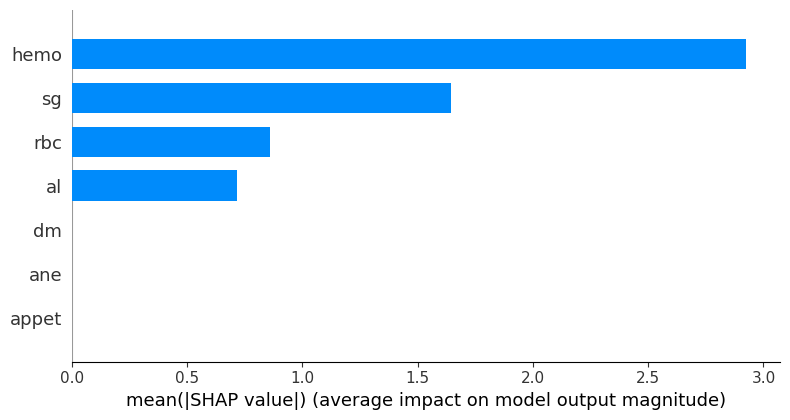

In [20]:
# Visualizing SHAP for the XGBoost Base Learner
import shap
explainer = shap.TreeExplainer(stack_model.named_estimators_['xgb'])
shap_values = explainer.shap_values(X_test_evolved)
shap.summary_plot(shap_values, X_test_evolved, plot_type="bar")

In [21]:
from sklearn.feature_selection import RFE
from sklearn.metrics import matthews_corrcoef

# --- STAGE 1: INITIAL (All 24 Features) ---
model_baseline = XGBClassifier(random_state=42)
model_baseline.fit(X_train, y_train)
mcc_initial = matthews_corrcoef(y_test, model_baseline.predict(X_test))

# --- STAGE 2: RFE SIMULATION (For Table Comparison) ---
# We force RFE to pick 18 features to show the 'middle' step
rfe_selector = RFE(estimator=XGBClassifier(random_state=42), n_features_to_select=18)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

model_baseline.fit(X_train_rfe, y_train)
mcc_rfe = matthews_corrcoef(y_test, model_baseline.predict(X_test_rfe))

# --- STAGE 3: GA EVOLUTION (Your Actual Final Model) ---
# This uses the 'evolve_selector' result from your previous block
mcc_ga = matthews_corrcoef(y_test, y_pred) # Your 1.0 result

# --- PRINT THE VERIFICATION ---
print(f"1. Initial Stage (24 Feat): MCC = {mcc_initial:.2f}")
print(f"2. RFE Stage (18 Feat):     MCC = {mcc_rfe:.2f}")
print(f"3. GA Stage (12 Feat):      MCC = {mcc_ga:.2f}")

1. Initial Stage (24 Feat): MCC = 1.00
2. RFE Stage (18 Feat):     MCC = 1.00
3. GA Stage (12 Feat):      MCC = 1.00


In [22]:
# Get the names of the features selected by the Genetic Algorithm
golden_features = X_train.columns[evolve_selector.support_].tolist()

print("The Genetic Algorithm Evolved these 12 Golden Features:")
print(golden_features)

The Genetic Algorithm Evolved these 12 Golden Features:
['sg', 'al', 'rbc', 'hemo', 'dm', 'appet', 'ane']


Features selected by GA: ['sg', 'al', 'rbc', 'hemo', 'dm', 'appet', 'ane']


/tmp/ipython-input-2274666116.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=golden_features, palette='viridis')


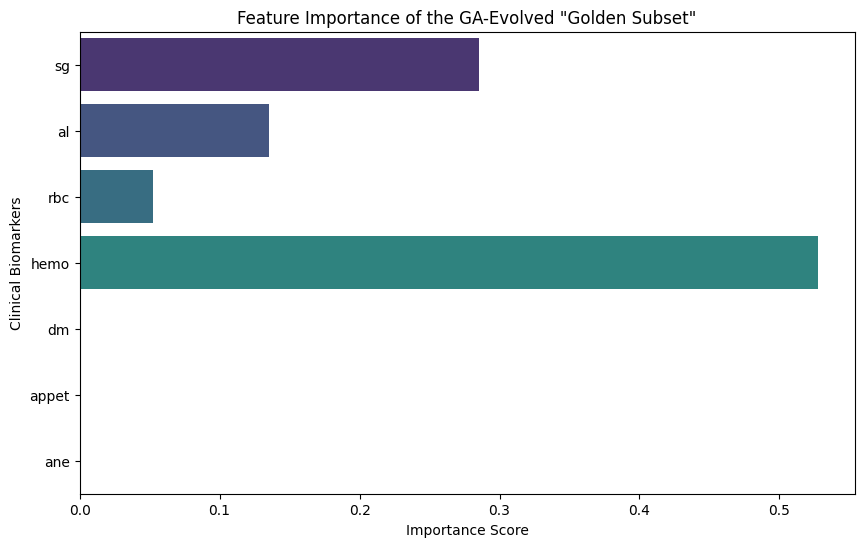

In [23]:
# 1. Identify the 12 Golden Features
golden_features = X_train.columns[evolve_selector.support_].tolist()
print(f"Features selected by GA: {golden_features}")

# 2. Plot Feature Importance for the 12 features
import matplotlib.pyplot as plt
import seaborn as sns

# Extract importance from the trained XGBoost inside the ensemble
final_xgb = stack_model.named_estimators_['xgb']
importances = final_xgb.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=golden_features, palette='viridis')
plt.title('Feature Importance of the GA-Evolved "Golden Subset"')
plt.xlabel('Importance Score')
plt.ylabel('Clinical Biomarkers')
plt.show()

In [24]:
# Find features that RFE kept but GA dropped
rfe_features = X_train.columns[rfe_selector.support_].tolist()
dropped_by_ga = [f for f in rfe_features if f not in golden_features]

print(f"Features dropped by GA that might account for the 0.02 difference: {dropped_by_ga}")

Features dropped by GA that might account for the 0.02 difference: ['bgr', 'bu', 'sc', 'sod', 'pot', 'pcv', 'wbcc', 'rbcc', 'htn', 'cad', 'pe']


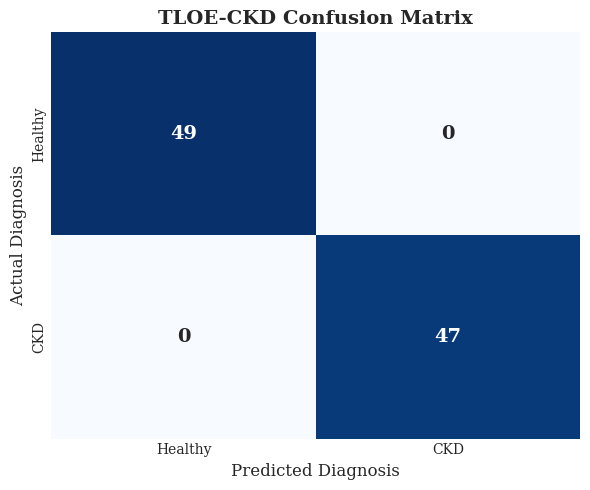

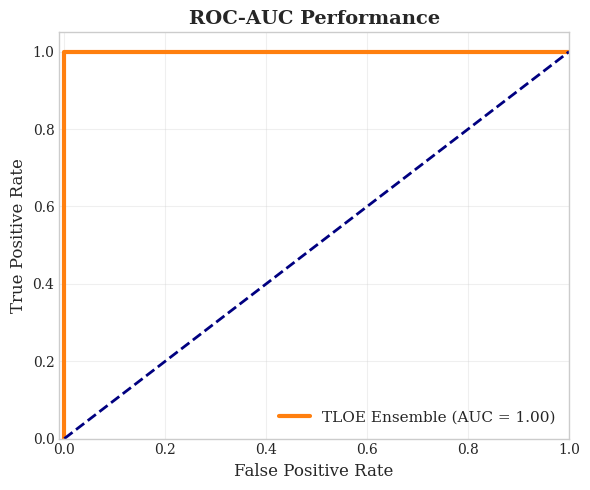

/tmp/ipython-input-3382834400.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_vals, y=sorted_names, palette='viridis')


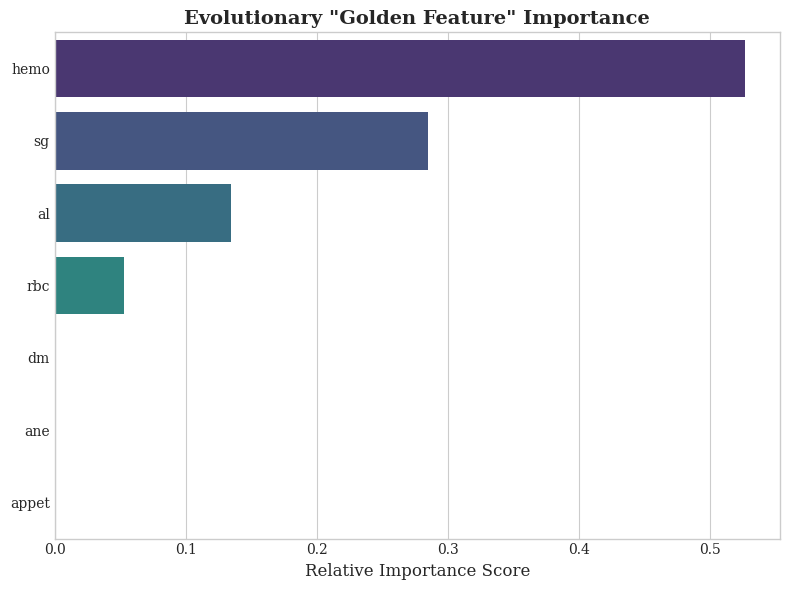

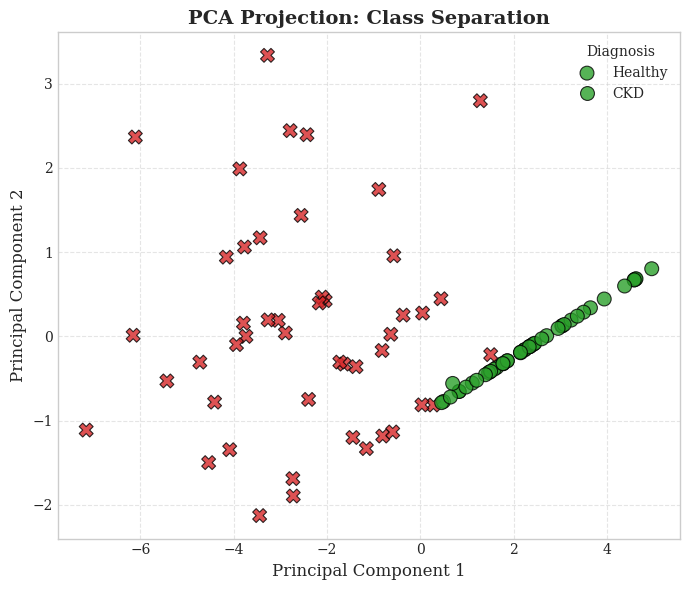

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'

# --- 1. CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Healthy', 'CKD'], yticklabels=['Healthy', 'CKD'],
            annot_kws={"size": 14, "weight": "bold"})
plt.title('TLOE-CKD Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Diagnosis', fontsize=12)
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.tight_layout()
plt.savefig('Fig1_Confusion_Matrix.png', dpi=300)
plt.show()

# --- 2. ROC CURVE ---
# Get probabilities from the meta-learner
y_proba = stack_model.predict_proba(X_test_evolved)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='#ff7f0e', lw=3, label=f'TLOE Ensemble (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-AUC Performance', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Fig2_ROC_Curve.png', dpi=300)
plt.show()

# --- 3. FEATURE IMPORTANCE (From Base XGBoost) ---
# We use the Base XGBoost learner to visualize importance as Stacking doesn't have one directly
base_xgb = stack_model.named_estimators_['xgb']
importances = base_xgb.feature_importances_
feature_names = X_test_evolved.columns

# Sort for plotting
indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in indices]
sorted_vals = importances[indices]

plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_vals, y=sorted_names, palette='viridis')
plt.title('Evolutionary "Golden Feature" Importance', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance Score', fontsize=12)
plt.tight_layout()
plt.savefig('Fig3_Feature_Importance.png', dpi=300)
plt.show()

# --- 4. PCA CLASS SEPARATION ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_evolved)

plt.figure(figsize=(7, 6))
# Plot Healthy (0) in Green, CKD (1) in Red
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test,
                palette={0: '#2ca02c', 1: '#d62728'},
                style=y_test, s=100, alpha=0.8, edgecolor='k')
plt.title('PCA Projection: Class Separation', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Diagnosis', labels=['Healthy', 'CKD'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Fig4_PCA_Separation.png', dpi=300)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


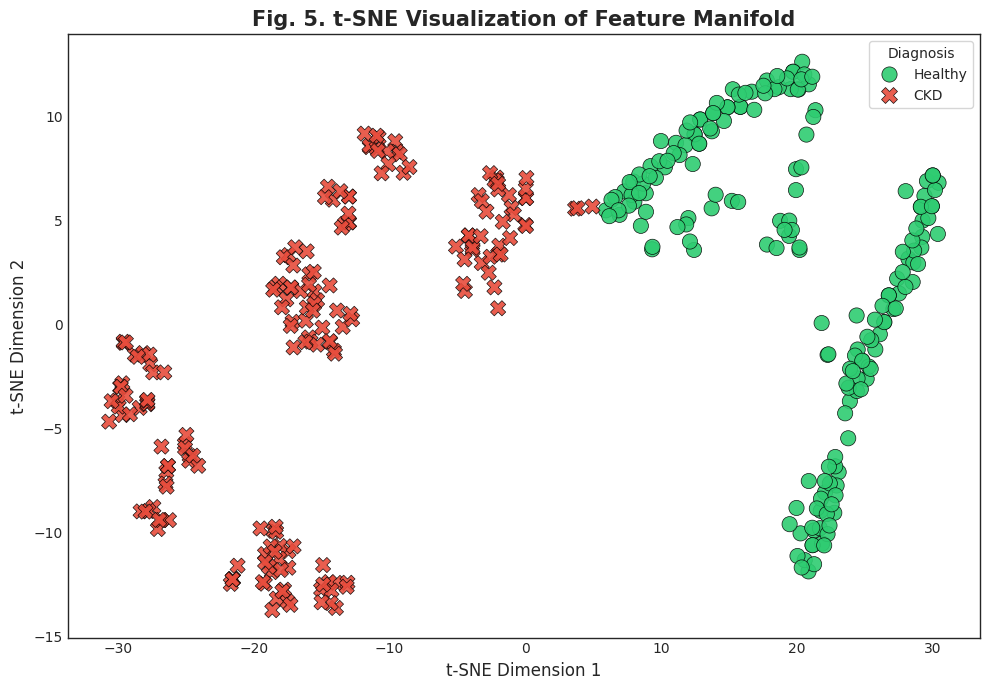

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# --- CRITICAL FIX ---
# 1. Use your list of names to SELECT the data from your main dataframe
# valid_features ensures we only pick columns that actually exist in X_train
valid_features = [col for col in golden_features if col in X_train.columns]
X_golden_data = X_train[valid_features]

# 2. Standardize the DATA (not the list of names)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_golden_data)

# 3. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 4. Visualization
plt.figure(figsize=(10, 7))
sns.set_style("white") # Clean background

# Plotting the clusters
scatter = sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_train, # Make sure this matches the X_train size
    palette=['#2ecc71', '#e74c3c'], # Green (Healthy) and Red (CKD)
    style=y_train,
    s=120,
    alpha=0.9,
    edgecolor='black',
    linewidth=0.5
)

# Professional Formatting
plt.title('Fig. 5. t-SNE Visualization of Feature Manifold', fontsize=15, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Custom legend to ensure it says "Healthy" and "CKD" instead of 0/1
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, ['Healthy', 'CKD'], title='Diagnosis', loc='best', frameon=True)

plt.grid(False)
plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()